
Решить системы ОДУ следующими классами методов:

1) Явные методы Рунге-Кутта от 1 до 4 порядка
2) Явные методы Адамса от 2 до 4 порядка (внимание разгонный участок!)
3) Явные методы Формулы Дифференцирования Назад от 2 до 4 порядка (внимание разгонный участок!)

Формулы явных методов некоторые писали ранее на семинарах, либо в пособиях можно найти, либо загуглить .

Под решением понимается - вывод графика интегральных кривых при заданном h (шаге интегрирования), когда наблюдается устойчивая картина решения - отдельно по семействам методов


![Задача](task.png)

In [55]:
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# rk
def euler_step(f, u, h):
    return u + h * f(u)

def rk2_step(f, u, h):
    k1 = f(u)
    k2 = f(u + h * k1)
    return u + 0.5 * h * (k1 + k2)

def heun3_step(f, u, h):
    k1 = f(u)
    k2 = f(u + (h/3) * k1)
    k3 = f(u + (2*h/3) * k2)
    return u + (h/4) * (k1 + 3*k3)

def rk4_step(f, u, h):
    k1 = f(u)
    k2 = f(u + 0.5 * h * k1)
    k3 = f(u + 0.5 * h * k2)
    k4 = f(u + h * k3)
    return u + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

In [57]:
def initialize_values(u0, t0, h, m):
    t_vals = [t0]
    u_vals = [u0]
    for i in range(1, m):
        u_next = rk4_step(f, u_vals[i-1], h)
        t_vals.append(t_vals[i-1] + h)
        u_vals.append(u_next)
    return np.array(t_vals), np.array(u_vals)

def adams_2_step(u_vals, f_vals, h):
    return u_vals[-1] + 0.5 * h * (3*f_vals[-1] - f_vals[-2])

def adams_3_step(u_vals, f_vals, h):
    return u_vals[-1] + (h/12) * (23*f_vals[-1] - 16*f_vals[-2] + 5*f_vals[-3])

def adams_4_step(u_vals, f_vals, h):
    return u_vals[-1] + (h/24) * (55*f_vals[-1] - 59*f_vals[-2] + 37*f_vals[-3] - 9*f_vals[-4])

def solve_adams_global(f, u0, t0, h, nsteps, m):
    """
    Решает ОДУ методом Адамса–Башфорта порядка m (2, 3 или 4)
    с разгонной фазой (m первых шагов) методом РК4.
    """
    t_vals, u_vals = initialize_values(u0, t0, h, m)
    f_vals = [f(u) for u in u_vals]
    for _ in range(m-1, nsteps):
        if m == 2:
            u_next = adams_2_step(u_vals, f_vals, h)
        elif m == 3:
            u_next = adams_3_step(u_vals, f_vals, h)
        elif m == 4:
            u_next = adams_4_step(u_vals, f_vals, h)
        else:
            raise ValueError("Порядок метода Адамса должен быть 2, 3 или 4")
        t_next = t_vals[-1] + h
        t_vals = np.append(t_vals, t_next)
        u_vals = np.vstack([u_vals, u_next])
        f_vals.append(f(u_next))
    return t_vals, u_vals



In [58]:
def bdf_step_fixed_point(f, rhs, gamma, u_guess, h, tol=1e-9, max_iter=50):
    u_curr = u_guess.copy()
    for iteration in range(max_iter):
        u_next = rhs + gamma * h * f(u_curr)
        if np.linalg.norm(u_next - u_curr, ord=np.inf) < tol:
            return u_next, iteration+1
        u_curr = u_next
    return u_curr, max_iter

def bdf2_step(f, u_n, u_n1, h):
    rhs = (4/3)*u_n1 - (1/3)*u_n
    gamma = 2/3
    u_guess = u_n1
    u_n2, _ = bdf_step_fixed_point(f, rhs, gamma, u_guess, h)
    return u_n2

def bdf3_step(f, u_n, u_n1, u_n2, h):
    rhs = (18/11)*u_n2 - (9/11)*u_n1 + (2/11)*u_n
    gamma = 6/11
    u_guess = u_n2
    u_n3, _ = bdf_step_fixed_point(f, rhs, gamma, u_guess, h)
    return u_n3

def bdf4_step(f, u_n, u_n1, u_n2, u_n3, h):
    rhs = (48/25)*u_n3 - (36/25)*u_n2 + (16/25)*u_n1 - (3/25)*u_n
    gamma = 12/25
    u_guess = u_n3
    u_n4, _ = bdf_step_fixed_point(f, rhs, gamma, u_guess, h)
    return u_n4

def solve_bdf_global(f, u0, t0, h, nsteps, order):
    if order == 2:
        u1 = rk4_step(f, u0, h)
        t_vals = [t0, t0+h]
        u_vals = [u0, u1]
        for n in range(1, nsteps):
            t_next = t0 + (n+1)*h
            u_next = bdf2_step(f, u_vals[-2], u_vals[-1], h)
            t_vals.append(t_next)
            u_vals.append(u_next)
        return np.array(t_vals), np.array(u_vals)
    elif order == 3:
        t_init, u_init = initialize_values(u0, t0, h, 3)
        t_vals = list(t_init)
        u_vals = list(u_init)
        for n in range(2, nsteps):
            t_next = t0 + (n+1)*h
            u_next = bdf3_step(f, u_vals[-3], u_vals[-2], u_vals[-1], h)
            t_vals.append(t_next)
            u_vals.append(u_next)
        return np.array(t_vals), np.array(u_vals)
    elif order == 4:
        t_init, u_init = initialize_values(u0, t0, h, 4)
        t_vals = list(t_init)
        u_vals = list(u_init)
        for n in range(3, nsteps):
            t_next = t0 + (n+1)*h
            u_next = bdf4_step(f, u_vals[-4], u_vals[-3], u_vals[-2], u_vals[-1], h)
            t_vals.append(t_next)
            u_vals.append(u_next)
        return np.array(t_vals), np.array(u_vals)
    else:
        raise ValueError("Порядок метода BDF должен быть 2, 3 или 4")



In [ ]:
class ODESolver:
    def __init__(self, f, u0, t0, t_end, h):
        self.f = f
        self.u0 = u0
        self.t0 = t0
        self.t_end = t_end
        self.h = h
        self.nsteps = int((t_end - t0) / h)
    
    def solve(self, method, order=None):
        """
        Параметры:
          method - 'euler', 'rk2', 'heun3', 'rk4', 'adams', 'bdf'
          order  - для методов 'adams' и 'bdf': порядок (2, 3 или 4)
        Возвращает: (t_values, u_values, label)
        """
        if method in ['euler', 'rk2', 'heun3', 'rk4']:
            return self._solve_single(method)
        elif method == 'adams':
            if order not in [2, 3, 4]:
                raise ValueError("Для метода Адамса порядок должен быть 2, 3 или 4")
            return self._solve_adams(order)
        elif method == 'bdf':
            if order not in [2, 3, 4]:
                raise ValueError("Для метода BDF порядок должен быть 2, 3 или 4")
            return self._solve_bdf(order)
        else:
            raise ValueError("Неизвестный метод: " + method)
    
    def _solve_single(self, method):
        if method == 'euler':
            step_method = euler_step
            label = "Метод Эйлера (1-й порядок)"
        elif method == 'rk2':
            step_method = rk2_step
            label = "Рунге–Кутта 2-го порядка"
        elif method == 'heun3':
            step_method = heun3_step
            label = "3-стадийный метод Хойна (3-й порядок)"
        elif method == 'rk4':
            step_method = rk4_step
            label = "Рунге–Кутта 4-го порядка"
        else:
            raise ValueError("Неизвестный метод: " + method)
        
        t_values = np.linspace(self.t0, self.t_end, self.nsteps + 1)
        u_values = np.empty((self.nsteps + 1, len(self.u0)))
        u_values[0] = self.u0
        for i in range(self.nsteps):
            u_values[i+1] = step_method(self.f, u_values[i], self.h)
        return t_values, u_values, label
    
    def _solve_adams(self, m):
        t_vals, u_vals = initialize_values(self.u0, self.t0, self.h, m)
        f_vals = [self.f(u) for u in u_vals]
        for n in range(m-1, self.nsteps):
            if m == 2:
                u_next = adams_2_step(u_vals, f_vals, self.h)
            elif m == 3:
                u_next = adams_3_step(u_vals, f_vals, self.h)
            elif m == 4:
                u_next = adams_4_step(u_vals, f_vals, self.h)
            else:
                raise ValueError("Порядок метода Адамса должен быть 2, 3 или 4")
            t_next = t_vals[-1] + self.h
            t_vals = np.append(t_vals, t_next)
            u_vals = np.vstack([u_vals, u_next])
            f_vals.append(self.f(u_next))
        label = f"Метод Адамса {m}-го порядка"
        return t_vals, u_vals, label
    
    def _solve_bdf(self, order):
        t_vals, u_vals = solve_bdf_global(self.f, self.u0, self.t0, self.h, self.nsteps, order)
        label = f"Метод BDF {order}-го порядка"
        return t_vals, u_vals, label




In [53]:
def f(u):
    x, y = u
    return np.array([y, x**2 - 1], dtype=float)

u0 = np.array([0.0, 0.0])
t0 = 0.0
t_end = 50.0
h = 0.01

solver = ODESolver(f, u0, t0, t_end, h)


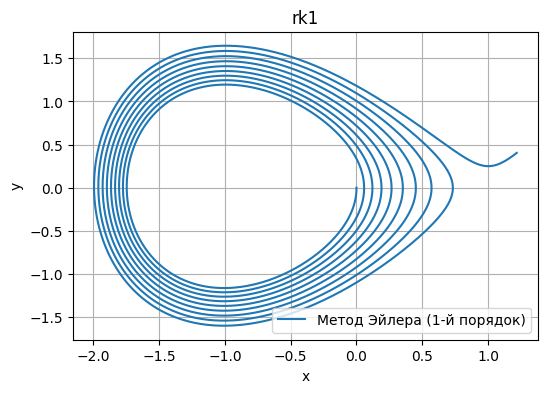

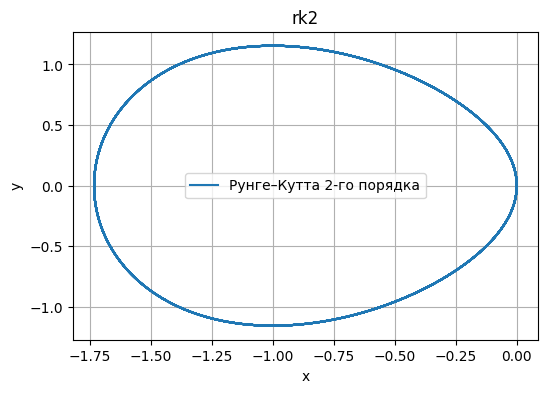

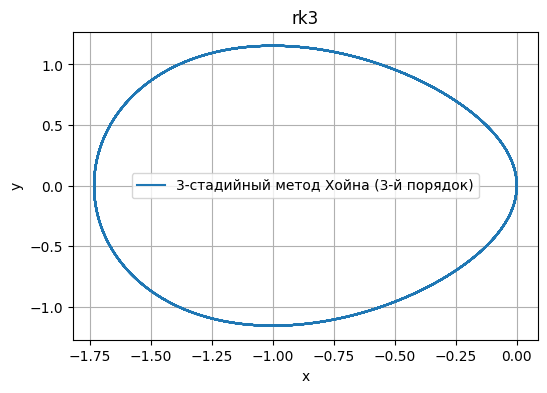

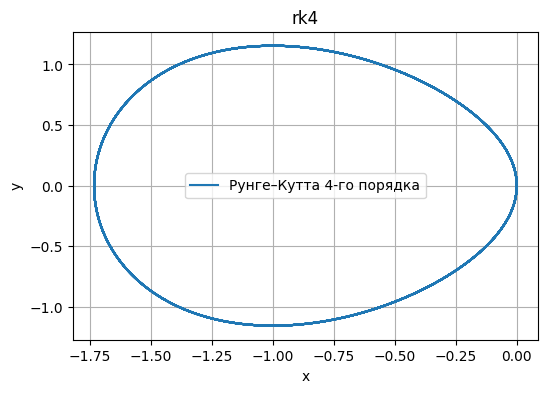

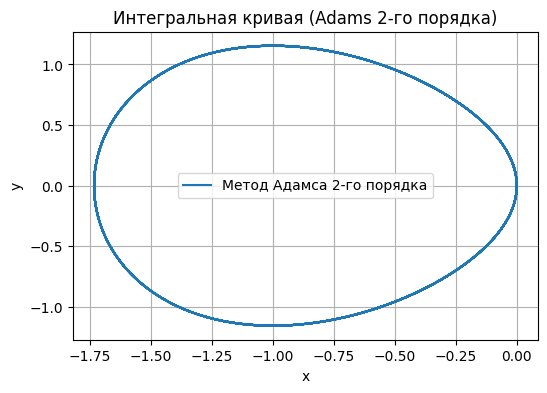

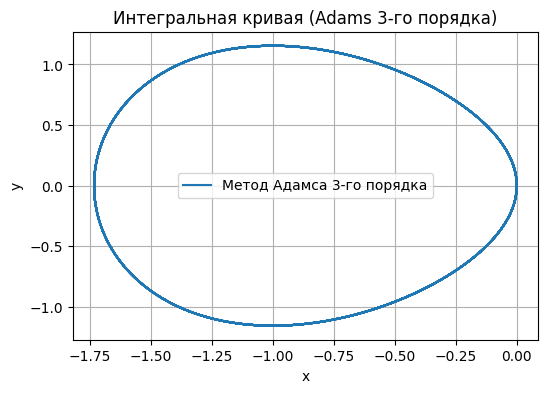

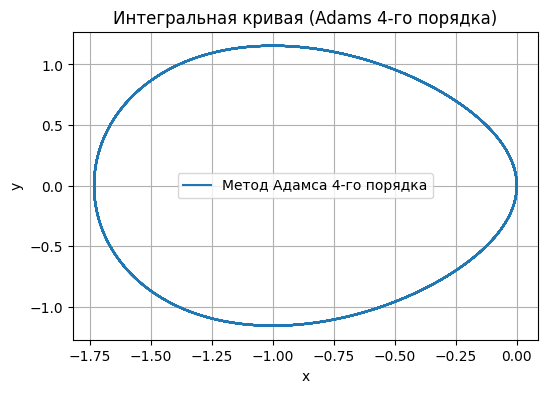

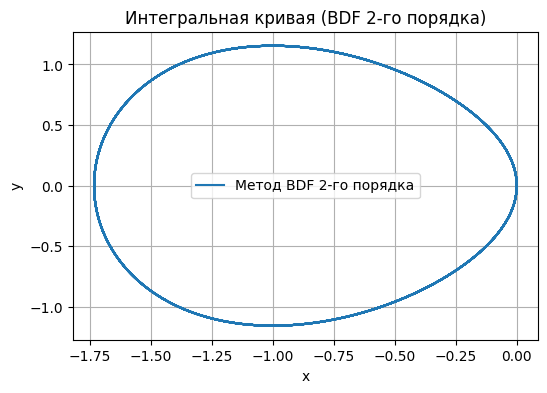

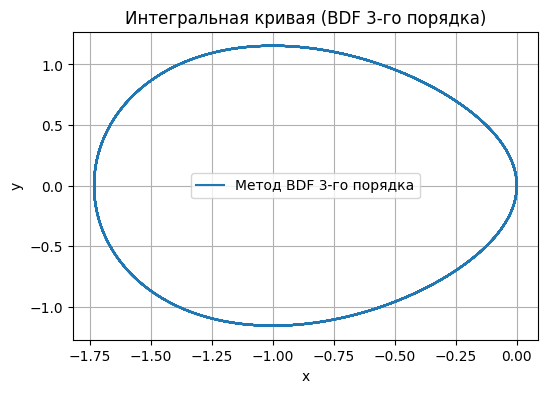

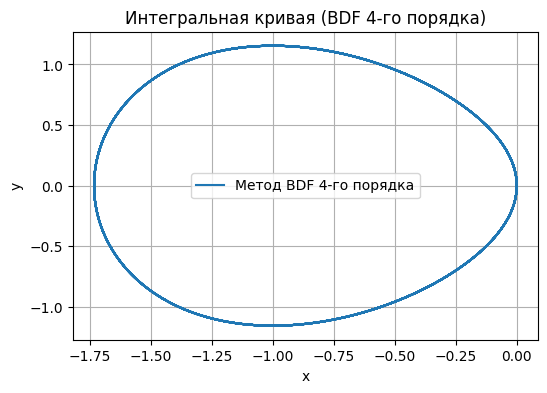

In [54]:
t_vals, u_vals, label = solver.solve('euler')
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("rk1")
plt.grid(True)
plt.legend()
plt.show()

t_vals, u_vals, label = solver.solve('rk2')
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("rk2")
plt.grid(True)
plt.legend()
plt.show()


t_vals, u_vals, label = solver.solve('heun3')
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("rk3")
plt.grid(True)
plt.legend()
plt.show()


t_vals, u_vals, label = solver.solve('rk4')
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("rk4")
plt.grid(True)
plt.legend()
plt.show()

t_vals, u_vals, label = solver.solve('adams', order=2)
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Интегральная кривая (Adams 2-го порядка)")
plt.grid(True)
plt.legend()
plt.show()


t_vals, u_vals, label = solver.solve('adams', order=3)
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Интегральная кривая (Adams 3-го порядка)")
plt.grid(True)
plt.legend()
plt.show()


t_vals, u_vals, label = solver.solve('adams', order=4)
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Интегральная кривая (Adams 4-го порядка)")
plt.grid(True)
plt.legend()
plt.show()

t_vals, u_vals, label = solver.solve('bdf', order=2)
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Интегральная кривая (BDF 2-го порядка)")
plt.grid(True)
plt.legend()


# Пример: метод BDF 3-го порядка
t_vals, u_vals, label = solver.solve('bdf', order=3)
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Интегральная кривая (BDF 3-го порядка)")
plt.grid(True)
plt.legend()

t_vals, u_vals, label = solver.solve('bdf', order=4)
plt.figure(figsize=(6,4))
plt.plot(u_vals[:, 0], u_vals[:, 1], label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Интегральная кривая (BDF 4-го порядка)")
plt.grid(True)
plt.legend()



# Явный фдн ?

![Задача](yfdn.png)

даже при k >= 3

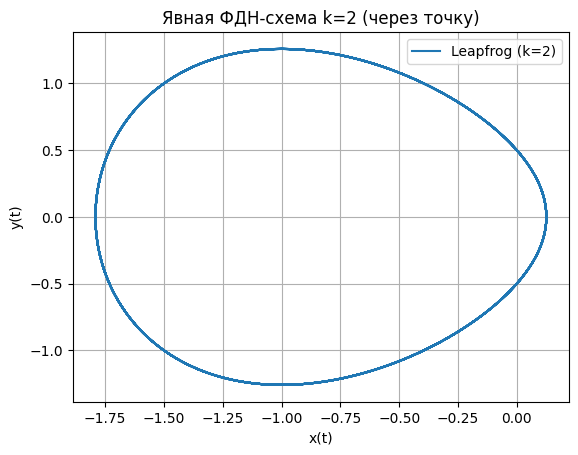

In [61]:
def euler_explicit(u_n, h):
    return u_n + h*f(u_n)

    return u_nm1 + 2*h*f(u_n)

def explicit_k3_step(u_nm2, u_n, h):
    return 3*h*f(u_n) - 1.5*u_n + 0.5*u_nm2


def solve_leapfrog(u0, t0, h, nsteps):
    t_vals = np.zeros(nsteps+1)
    u_vals = np.zeros((nsteps+1, len(u0)))
    
    t_vals[0] = t0
    u_vals[0] = u0
    
    u1 = euler_explicit(u0, h)
    t_vals[1] = t0 + h
    u_vals[1] = u1
    
    # основной цикл:
    for n in range(1, nsteps):
        t_vals[n+1] = t_vals[n] + h
        u_vals[n+1] = leapfrog_step(u_vals[n-1], u_vals[n], h)
    
    return t_vals, u_vals

h = 0.01
t0 = 0.0
t_max = 50.0
nsteps = int((t_max - t0)/h)
u0 = np.array([0.0, 0.5])  

t_lf, u_lf = (u0, t0, h, nsteps)
x_vals = u_lf[:,0]
y_vals = u_lf[:,1]

plt.figure()
plt.plot(x_vals, y_vals, label="Leapfrog (k=2)")
plt.title("Явная ФДН-схема k=2 (через точку)")
plt.xlabel("x(t)")
plt.ylabel("y(t)")
plt.grid(True)
plt.legend()
plt.show()


/var/folders/wf/668bg_rx2yz5wvf7tvqh_bm40000gq/T/ipykernel_34417/4265813821.py:3: RuntimeWarning: overflow encountered in scalar power
  return np.array([y, x**2 - 1], dtype=float)
/var/folders/wf/668bg_rx2yz5wvf7tvqh_bm40000gq/T/ipykernel_34417/451939508.py:21: RuntimeWarning: invalid value encountered in subtract
  return 3*h*f(u_n) - 1.5*u_n + 0.5*u_nm2


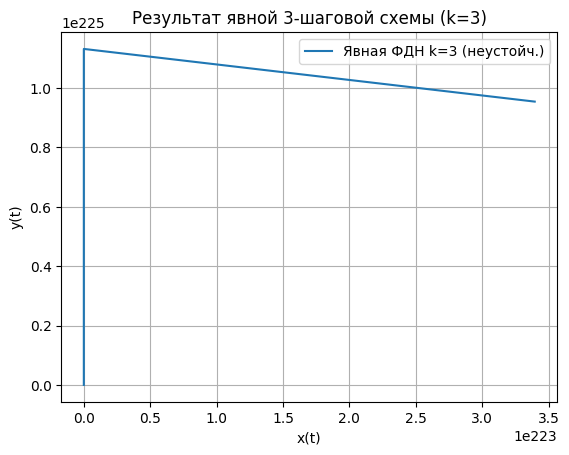

In [ ]:
def solve_explicit_k3(u0, h, nsteps):
    u_vals = np.zeros((nsteps+1, len(u0)))
    t_vals = np.zeros(nsteps+1)
    u_vals[0] = u0

    u1 = euler_explicit(u0, h)
    u_vals[1] = u1
    u2 = euler_explicit(u1, h)
    u_vals[2] = u2

    for n in range(2, nsteps):
        u_nm2 = u_vals[n-2]
        u_n   = u_vals[n]
        u_next = explicit_k3_step(u_nm2, u_n, h)
        u_vals[n+1] = u_next
        t_vals[n+1] = (n+1)*h

    return t_vals, u_vals

h = 0.01
nsteps = 500  
u0 = np.array([0.0, 0.0])  

t_k3, u_k3 = solve_explicit_k3(u0, h, nsteps)
x_k3 = u_k3[:,0]
y_k3 = u_k3[:,1]

plt.figure()
plt.plot(x_k3, y_k3, label="Явная ФДН k=3 (неустойч.)")
plt.xlabel("x(t)")
plt.ylabel("y(t)")
plt.title("Результат явной 3-шаговой схемы (k=3)")
plt.grid(True)
plt.legend()
plt.show()

/var/folders/wf/668bg_rx2yz5wvf7tvqh_bm40000gq/T/ipykernel_34417/4265813821.py:3: RuntimeWarning: overflow encountered in scalar power
  return np.array([y, x**2 - 1], dtype=float)
/var/folders/wf/668bg_rx2yz5wvf7tvqh_bm40000gq/T/ipykernel_34417/3938780332.py:6: RuntimeWarning: invalid value encountered in subtract
  return (4.0*h*f(u_n)


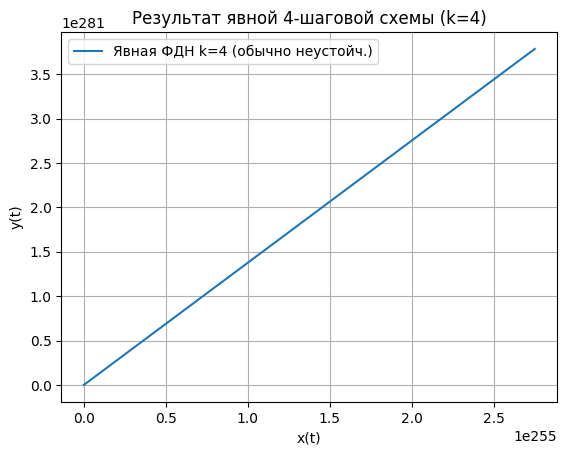

In [66]:
def explicit_k4_step(u_nm3, u_nm2, u_nm1, u_n, h, f):
    """
    Явная "4-шаговая ФДН" (формально 4-го порядка),
    y_{n+1} = 4 h f_n - (10/3) y_n + 6 y_{n-1} + 2 y_{n-2} - (1/3) y_{n-3}.
    """
    return (4.0*h*f(u_n)
            - (10.0/3.0)*u_n
            + 6.0*u_nm1
            + 2.0*u_nm2
            - (1.0/3.0)*u_nm3)

def solve_explicit_k4(u0, h, nsteps):
    u_vals = np.zeros((nsteps+1, len(u0)))
    t_vals = np.zeros(nsteps+1)
    u_vals[0] = u0
    
    u1 = u0 + h*f(u0)
    u2 = u1 + h*f(u1)
    u3 = u2 + h*f(u2)
    u_vals[1] = u1
    u_vals[2] = u2
    u_vals[3] = u3
    
    for n in range(3, nsteps):
        u_nm3 = u_vals[n-3]
        u_nm2 = u_vals[n-2]
        u_nm1 = u_vals[n-1]
        u_n   = u_vals[n]
        u_next = explicit_k4_step(u_nm3, u_nm2, u_nm1, u_n, h, f)
        u_vals[n+1] = u_next
        t_vals[n+1] = (n+1)*h
    
    return t_vals, u_vals

def demo_k4():
    h = 0.01
    nsteps = 500
    u0 = np.array([0.0, 0.5])
    
    t_k4, u_k4 = solve_explicit_k4(u0, h, nsteps)
    x_k4 = u_k4[:,0]
    y_k4 = u_k4[:,1]
    
    plt.figure()
    plt.plot(x_k4, y_k4, label="Явная ФДН k=4 (обычно неустойч.)")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.title("Результат явной 4-шаговой схемы (k=4)")
    plt.grid(True)
    plt.legend()
    plt.show()

demo_k4()
